## Enhancing Policing Decision-Making with Crime Forecasting
Crime forecasting plays a pivotal role in enhancing policing decision-making processes. The primary objective of this project is to develop a two-week crime forecasting model. Our aim is to predict the incidents of crime that may occur in Los Angeles.

To achieve this, we leverage a publicly available dataset titled "Crime Data from 2020 to Present," accessible via the website: https://data.lacity.org/. This dataset provides a comprehensive record of reported crimes within the City of Los Angeles, dating back to 2020.

It's worth noting that this data is transcribed from original crime reports, which are traditionally documented on paper. Consequently, there may be some inherent inaccuracies in the dataset. However, these inaccuracies are unlikely to impact the performance of our approach significantly, as they primarily pertain to unused variables.

The univariate dataset we work with comprises two main components:

"Occurrences": This variable represents the daily total number of crimes reported in Los Angeles.

Date Index: A chronological reference for tracking the timing of these crime occurrences.

By focusing on these key elements, we aim to develop a robust crime forecasting model that can assist law enforcement agencies in proactive decision-making and resource allocation.

## Data Pre-processing for Statistical Time Series Analysis

Statistical time series analysis relies on specific assumptions to yield reliable results. This process involves addressing missing values, handling outliers, and transforming the time series data to achieve stationarity. Let's delve into these assumptions in more detail:
    
#### Missing values:
Detecting and managing missing values is an essential initial step. Given the unique characteristics of each time series, a data scientist must choose an appropriate approach. Possible methods include imputing missing values with statistical measures such as the mean or median, or applying advanced imputation techniques.

#### Outliers:
Outliers can significantly skew results, making it crucial to address them. While the common approach is to remove outliers, this can result in a loss of valuable information. An alternative is to identify outliers using Tukey's method and replace them with the mean of neighboring values. This approach strikes a balance between data integrity and outlier mitigation.

#### Stationarity:

Stationarity is a key assumption in time series analysis, and there are two prominent statistical methods to assess it:

Augmented Dickey-Fuller Test (ADF): This test detects unit roots in time series data. Rejecting the null hypothesis indicates that the series is stationary, making it suitable for analysis.

Kwiatkowski Phillips Schmidt Shin (KPSS) Test: KPSS examines whether a time series is stationary around a mean or linear trend. Rejecting the null hypothesis suggests non-stationarity, prompting the need for transformation.

In addition to these tests, achieving stationarity often requires applying statistical transformations. These can include logarithmic, square root, cube root, Box-Cox, square power, exponential power, and differencing transformations. Visualizing the data after transformation and assessing critical values from stationary tests aids in selecting the most appropriate transformation method.

To initiate the data pre-processing, the first step involves importing the time series data and visualizing it. This initial exploration sets the foundation for subsequent analysis.

By following these steps diligently, data pre-processing ensures that the time series data is prepared optimally for robust statistical analysis. If you have any specific inquiries or require further guidance on these procedures, please do not hesitate to seek clarification.

            Occurrence Count
DATE OCC                    
2020-01-02               527
2020-01-03               595
2020-01-04               540
2020-01-05               505
2020-01-06               593
...                      ...
2023-09-20               502
2023-09-21               479
2023-09-22               474
2023-09-23               415
2023-09-24               403

[1362 rows x 1 columns]


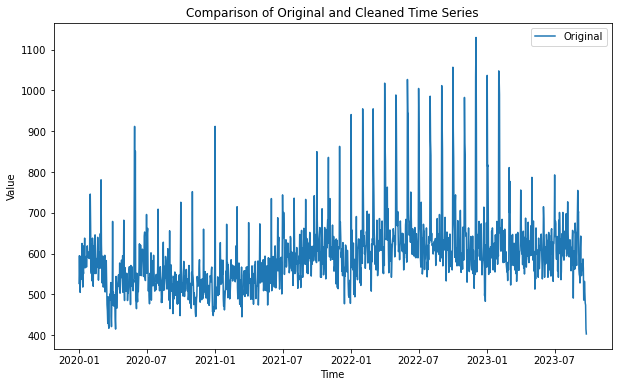

In [12]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# URL of the JSON API
url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.json?accessType=DOWNLOAD"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON data from the response
    data = response.json()

    # Extract the data rows from the JSON
    rows = data['data']

    # Extract the column names from the JSON
    columns = [column['name'] for column in data['meta']['view']['columns']]

    # Create a DataFrame using the extracted data and columns
    df = pd.DataFrame(rows, columns=columns)
    
    # Now you can work with the 'df' DataFrame
else:
    print("Failed to fetch data from the URL.")

# Convert the "DATE OCC" column to datetime if it's not already
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"])

# Group the data by the date and count occurrences
daily_occurrences_df = df.groupby(df["DATE OCC"].dt.date).size().to_frame(name="Occurrence Count")

# Exclude the initial and final extreme values
daily_occurrences_df = daily_occurrences_df.iloc[1:-1]

# Display the resulting DataFrame
print(daily_occurrences_df)


plt.figure(figsize=(10, 6))
plt.plot(daily_occurrences_df, label='Original')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of Original and Cleaned Time Series')
plt.show()

The following Python class named TimeSeriesPreparation performs various operations on a time series data, including data preprocessing and transformation. Here's a brief overview of what the code does:

It imports necessary libraries like NumPy, Matplotlib, SciPy, Pandas, Statsmodels, pmdarima, and more.

The TimeSeriesPreparation class is defined, which takes a time series as input during initialization.

Methods within the class include:

check_missing_values: Checks for missing values in the time series and prints whether any are present.

fill_missing_values: If missing values exist, it fills them with a rolling mean.

check_stationarity: Uses the Augmented Dickey-Fuller test and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test to check the 
stationarity of the time series. Various transformation methods like logarithmic, square root, cube root, Box-Cox, square power, and exponential power transformations, which return the transformed time series.

apply_difference_transformation: Automatically determines the number of differences required for stationarity and applies differencing.

possible_transformations: Applies a set of transformations and selects the one that results in the lowest p-value for stationarity.

choose_preferred_transformation: Prompts the user to choose a preferred transformation method.
An instance of the TimeSeriesPreparation class is created at the end, taking a time series dataframe named daily_occurrences_df as input.

This class is designed to assist in preparing time series data for further analysis, including handling missing values, checking and achieving stationarity, and applying various transformations to optimize the data for modeling or forecasting.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pmd
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

class TimeSeriesPreparation:
    def __init__(self, time_series):
        self.time_series = time_series
        self.label = self.time_series.columns[0]
    
    def check_missing_values(self):
        missing_values = self.time_series.isnull().sum()
        if missing_values.values[0] == 0:
            print("There aren't missing values.")
        else:
            print(f"There are {missing_values} in the time series.")
        return missing_values
    
    def fill_missing_values(self):
        if self.check_missing_values() != 0:
            self.time_series = self.time_series.sort_index()
            self.time_series = self.time_series.fillna(self.time_series.rolling(window=7, min_periods=1).mean())
            print("Filled Series:")
            print(self.time_series)
    
    def check_stationarity(self):
        result = adfuller(self.time_series)
        if result[1] >= 0.05:
            print('The Augmented Dickey-Fuller test assumes that the time series is non-stationary since the p-value: %f' % result[1])
        else:
            print('The Augmented Dickey-Fuller test assumes that the time series is stationary since the p-value: %f' % result[1])

        result_kpss_ct = kpss(self.time_series, regression="ct")
        if result_kpss_ct[1] >= 0.05:
            print('The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is stationary since the p-value: %f' % result_kpss_ct[1])
        else:
            print('The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is non-stationary since the p-value: %f' % result_kpss_ct[1])
    
    def apply_difference_transformation(self):
        num = pmd.arima.ndiffs(self.time_series)
        print(f"The number of differences is {num}")
        diff_time_series = self.time_series.diff(num).dropna()
        return diff_time_series
    
    def invert_forecast_to_real_values(diff_pred, last_training_value):
        """
        Inverts forecasted differences to real values using the last observed value.

        Parameters:
            diff_pred (pandas.Series): A series of forecasted differences.
            last_training_value (float): The last observed value from the original series.

        Returns:
            pandas.DataFrame: A DataFrame containing the inverted series with real values.
        """
    
        # Initialize the inverted series with the last observed value
        inverted_series = [last_training_value]

        # Iterate through the forecasted differences and calculate inverted values
        for i in range(diff_pred.shape[0]):
            inverted_value = inverted_series[i] + diff_pred.iloc[i]
            inverted_series.append(inverted_value)

        # Convert the inverted series to a Pandas DataFrame
        inverted_series = pd.DataFrame(inverted_series[1:], index=diff_pred.index)

        return inverted_series

    def apply_log_transformation(self):
        log_time_series = np.log(self.time_series)
        return log_time_series
    
    def apply_sqrt_transformation(self):
        sqrt_time_series = np.sqrt(self.time_series)
        return sqrt_time_series
    
    def apply_cbrt_transformation(self):
        cbrt_time_series = np.cbrt(self.time_series)
        return cbrt_time_series
    
    def apply_boxcox_transformation(self):
        transformed_values, lambda_value = boxcox(self.time_series.squeeze())
        box_time_series = pd.Series(transformed_values)
        return box_time_series
    
    def apply_square_power_transformation(self):
        sqpower_time_series = np.square(self.time_series)
        return sqpower_time_series
    
    def apply_exp_power_transformation(self):
        exp_time_series = np.exp(self.time_series)
        return exp_time_series

    def possible_transformations(self):
        transformations = {
            "log": (self.apply_log_transformation, "Log Transformation"),
            "sqrt": (self.apply_sqrt_transformation, "Square Root Transformation"),
            "cbrt": (self.apply_cbrt_transformation, "Cube Root Transformation"),
            "boxcox": (self.apply_boxcox_transformation, "Box-Cox Transformation"),
            "square": (self.apply_square_power_transformation, "Square Power Transformation"),
            "exp": (self.apply_exp_power_transformation, "Exponential Power Transformation"),
            "diff": (self.apply_difference_transformation, "Difference Transformation")
        }
    
        min_adf_p_value = float('inf')  # Initialize with a high value
        best_transformation = None
    
        for transformation_name, (transformation_func, title) in transformations.items():
            if transformation_name == "diff":
                num = pmd.arima.ndiffs(self.time_series)
                print(f"The number of differences is {num}")
                transformed_data = self.time_series.diff(num).dropna()
            else:
                transformed_data = transformation_func()

            # Check for infinity values before further processing
            if np.isinf(transformed_data).any().any():
                print(f"{title} produces infinity values, so it is not applicable.")
                continue  # Skip this transformation

            plt.plot(transformed_data)
            plt.title(title)
            plt.show()

            result = adfuller(transformed_data)
            if result[1] >= 0.05:
                print('The Augmented Dickey-Fuller test assumes that the time series is non-stationary since the p-value: %f' % result[1])
                continue  # Skip this transformation

            # Update the best transformation if the p-value is lower than the current minimum
            result = adfuller(transformed_data)
            p_value = result[1]
            if p_value < min_adf_p_value:
                min_adf_p_value = p_value
                best_transformation = title

    # Check stationarity one last time for the original series
    #self.check_stationarity()

        print(f"The best transformation method is {best_transformation} with the lowest p-value: {min_adf_p_value}")


    def choose_preferred_transformation(self):
        # Ask the user to select one transformation
        print("Choose the preferred transformation method:")
        print("1. Difference Transformation")
        print("2. Log Transformation")
        print("3. Square Root Transformation")
        print("4. Cube Root Transformation")
        print("5. Box-Cox Transformation")
        print("6. Square Power Transformation")
        print("7. Exponential Power Transformation")
        
        choice = input("Enter the number of your choice: ")

        if choice == "1":
            trans_time_series = self.apply_difference_transformation()
        elif choice == "2":
            trans_time_series = self.apply_log_transformation()
        elif choice == "3":
            trans_time_series = self.apply_sqrt_transformation()
        elif choice == "4":
            trans_time_series = self.apply_cbrt_transformation()
        elif choice == "5":
            trans_time_series = self.apply_boxcox_transformation()
        elif choice == "6":
            trans_time_series = self.apply_square_power_transformation()
        elif choice == "7":
            trans_time_series = self.apply_exp_power_transformation()
        else:
            print("Invalid choice.")
            return None
        
        return trans_time_series

# Initialize TimeSeriesAnalysis object
ts_analysis = TimeSeriesPreparation(daily_occurrences_df)


The Python class, TimeSeriesHandler, is designed to handle time series data by performing the following operations:

Initialization: The class takes a pandas DataFrame as input, assuming it contains time series data in a single column. It stores the label of this column and extracts the data.

remove_outliers Method: This method identifies and removes outliers from the time series data using the Interquartile Range (IQR) method. You can specify a factor (default is 1.5) to control the sensitivity to outliers.

handle_outliers_with_mean Method: This method identifies and handles outliers by replacing them with the mean of neighboring values within a specified window. It uses the same IQR-based outlier detection as the remove_outliers method and allows you to define the window size.

check_stationarity Method: This method checks the stationarity of the time series data using two statistical tests: the Augmented Dickey-Fuller test (ADF) and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test. It prints whether the series is stationary or non-stationary based on the p-values of these tests.

plot_side_by_side Method: This method plots the original time series data alongside the cleaned data obtained from the remove_outliers method and the data handled with the mean of neighbors from the handle_outliers_with_mean method. It also prints the lengths of these time series for comparison.

In summary, this class provides a set of utility methods to preprocess and analyze time series data, particularly focusing on handling outliers and assessing stationarity. It can be a useful tool when working with time series datasets for various analytical tasks.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr

class TimeSeriesHandler:
    def __init__(self, data):
        self.label = data.columns[0]
        self.data = data.iloc[:,0]

    def remove_outliers(self, factor=1.5):
        q1 = np.percentile(self.data, 25)
        q3 = np.percentile(self.data, 75)
        iqr_value = iqr(self.data)
        lower_fence = q1 - factor * iqr_value
        upper_fence = q3 + factor * iqr_value
        cleaned_data = self.data[(self.data >= lower_fence) & (self.data <= upper_fence)]
        return pd.DataFrame({ self.label: cleaned_data})

    def handle_outliers_with_mean(self, window_size, factor=1.5):
        handled_data = self.data.copy()
        q1 = np.percentile(handled_data, 25)
        q3 = np.percentile(handled_data, 75)
        iqr_value = iqr(handled_data)
        lower_fence = q1 - factor * iqr_value
        upper_fence = q3 + factor * iqr_value
        lower_outliers = handled_data < lower_fence
        upper_outliers = handled_data > upper_fence
        outliers_indices = np.where(lower_outliers | upper_outliers)[0]
        for i in outliers_indices:
            lower_index = max(i - window_size, 0)
            upper_index = min(i + window_size, len(handled_data) - 1)
            non_outliers = [value for j, value in enumerate(handled_data) if lower_index <= j <= upper_index and j != i]
            handled_data.iloc[i] = np.mean(non_outliers)
        return pd.DataFrame({self.label: handled_data})

    def check_stationarity(self):
        result = adfuller(self.data)
        if result[1] >= 0.05:
            print('The Augmented Dickey-Fuller test assumes that the time series is non-stationary since the p-value: %f' % result[1])
        else:
            print('The Augmented Dickey-Fuller test assumes that the time series is stationary since the p-value: %f' % result[1])

        result_kpss_ct = kpss(self.data, regression="ct")
        if result_kpss_ct[1] >= 0.05:
            print('The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is stationary since the p-value: %f' % result_kpss_ct[1])
        else:
            print('The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is non-stationary since the p-value: %f' % result_kpss_ct[1])


    def plot_side_by_side(self, cleaned_data, handle_with_mean_data):
        original_length = len(self.data)
        cleaned_length = len(cleaned_data)
        handle_with_mean_length = len(handle_with_mean_data)

        # Create subplots with two columns
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # Plot the original and cleaned time series
        axs[0].plot(self.data, label='Original')
        axs[0].plot(cleaned_data, label='Cleaned')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Value')
        axs[0].legend()
        axs[0].set_title('Original vs. Cleaned Time Series')

        # Plot the original and cleaned time series with handling outliers using the mean of neighbors
        axs[1].plot(self.data, label='Original')
        axs[1].plot(handle_with_mean_data, label='handle_with_mean')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Value')
        axs[1].legend()
        axs[1].set_title('Original vs. handle_with_mean Time Series')

        # Print the number of time series values
        print(f"Original Time Series Length: {original_length}")
        print(f"Cleaned Time Series Length: {cleaned_length}")
        print(f"handle_with_mean Time Series Length: {handle_with_mean_length}")

        # Adjust layout to prevent overlapping titles and labels
        plt.tight_layout()

        # Show the plots
        plt.show()

The outliers removing transformation stationarity test indicates that:
The Augmented Dickey-Fuller test assumes that the time series is stationary since the p-value: 0.026799
The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is non-stationary since the p-value: 0.010000
The rolling mean transformation stationarity test indicates that:
The Augmented Dickey-Fuller test assumes that the time series is stationary since the p-value: 0.036244
The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is non-stationary since the p-value: 0.010000
Original Time Series Length: 1362
Cleaned Time Series Length: 1336
handle_with_mean Time Series Length: 1362


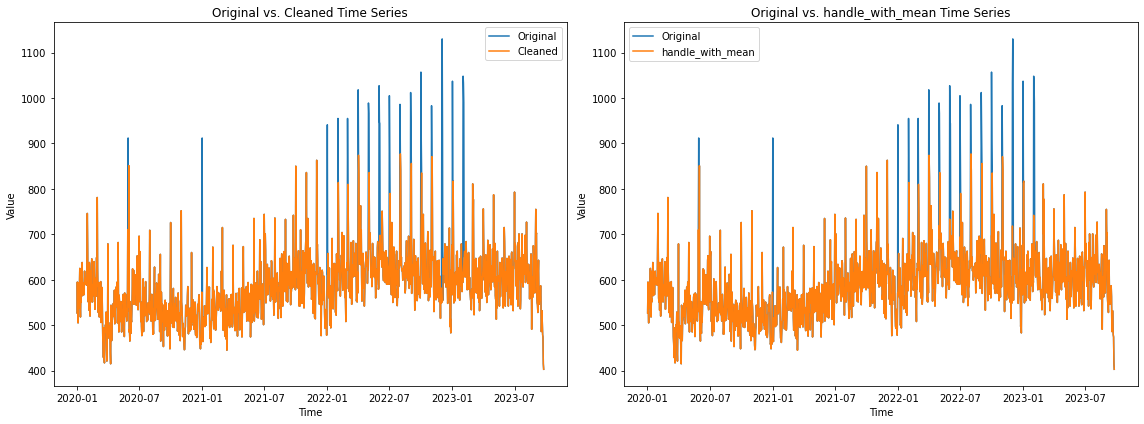

In [15]:
# Outliers' detection and handling
if __name__ == "__main__":

    # Create an instance of TimeSeriesHandler
    handler = TimeSeriesHandler(daily_occurrences_df)

    # Remove outliers using the remove_outliers method
    cleaned_data = handler.remove_outliers(factor=3)
    cleaned_handler = TimeSeriesHandler(cleaned_data)
    
    # Testing the stationarity of cleaned_data
    print("The outliers removing transformation stationarity test indicates that:")
    cleaned_handler.check_stationarity()

    # Handle outliers with the mean of neighbors
    handle_with_mean_data = handler.handle_outliers_with_mean(window_size=3, factor=3)
    mean_handler = TimeSeriesHandler(handle_with_mean_data)
    
    # Testing the stationarity of handle_with_mean_data
    print("The rolling mean transformation stationarity test indicates that:")
    mean_handler.check_stationarity()
    
    # Plot side by side and print the lengths
    handler.plot_side_by_side(cleaned_data, handle_with_mean_data)

The earlier results have unveiled two potential transformations. My preference leans towards employing the rolling mean smoothing method over outright removal. This choice allows me to retain valuable data points, preventing significant information loss and preserving the original distribution of the time series. As the next step, I will assess the presence of any missing values.

In [16]:
#Checking Missing values
ts_analysis = TimeSeriesPreparation(handle_with_mean_data)

TimeSeriesPreparation.check_missing_values(ts_analysis)

There aren't missing values.


Occurrence Count    0
dtype: int64

As established earlier, there are no missing values within the dataset. The concluding step involves scrutinizing the stationarity of the time series, examining potential transformations, and subsequently selecting the most stationary transformation method to proceed with.

In [17]:
#Checking stationarity
TimeSeriesPreparation.check_stationarity(ts_analysis)

The Augmented Dickey-Fuller test assumes that the time series is stationary since the p-value: 0.036244
The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is non-stationary since the p-value: 0.010000


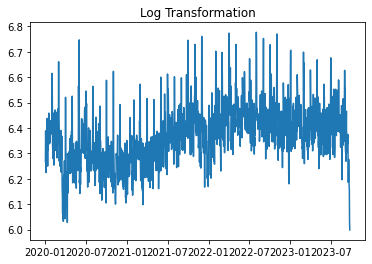

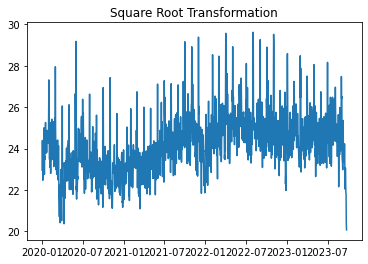

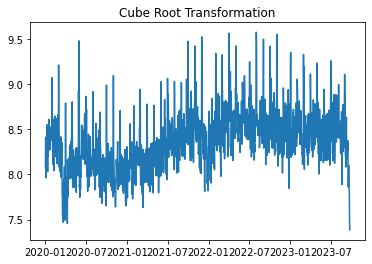

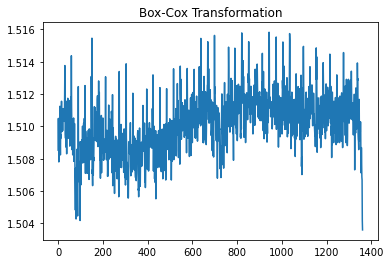

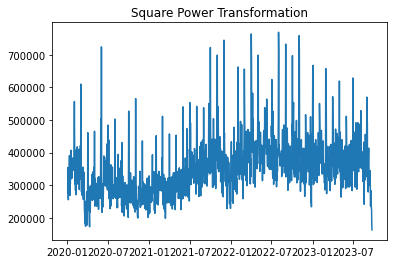

Exponential Power Transformation produces infinity values, so it is not applicable.
The number of differences is 1


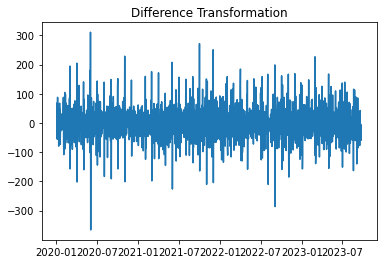

The best transformation method is Difference Transformation with the lowest p-value: 1.2373489512758619e-23


In [18]:
# Apply possible transformations and show plots
ts_analysis = TimeSeriesPreparation(handle_with_mean_data)

ts_analysis.possible_transformations()

In [19]:
# Prompt the user to choose the preferred transformation method
transformed_ts = ts_analysis.choose_preferred_transformation()

transformed_ts.head()

Choose the preferred transformation method:
1. Difference Transformation
2. Log Transformation
3. Square Root Transformation
4. Cube Root Transformation
5. Box-Cox Transformation
6. Square Power Transformation
7. Exponential Power Transformation
Enter the number of your choice: 1
The number of differences is 1


,Occurrence Count
DATE OCC,
2020-01-03,68.0
2020-01-04,-55.0
2020-01-05,-35.0
2020-01-06,88.0
2020-01-07,-55.0


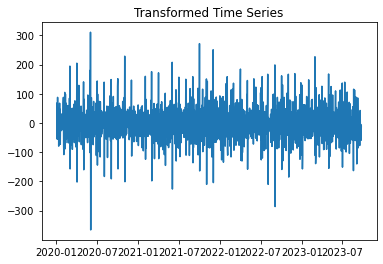

In [20]:
# Plot the transformed time series
plt.plot(transformed_ts)
plt.title("Transformed Time Series")
plt.show()

In [21]:
# Verification of stationarity
ts_analysis = TimeSeriesPreparation(transformed_ts)
ts_stationary = TimeSeriesPreparation.check_stationarity(ts_analysis)

The Augmented Dickey-Fuller test assumes that the time series is stationary since the p-value: 0.000000
The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests assumes that the time series is stationary since the p-value: 0.100000


Best p-value: 0.0 at lag 1
The time series is stationary (ADF with trend) since the p-value: 0.000000
Best p-value (KPSS with c trend): 0.1


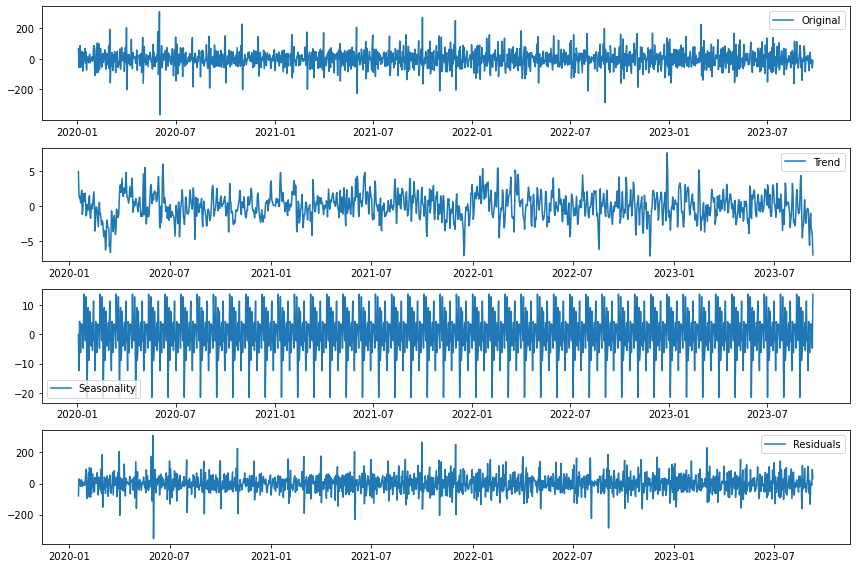

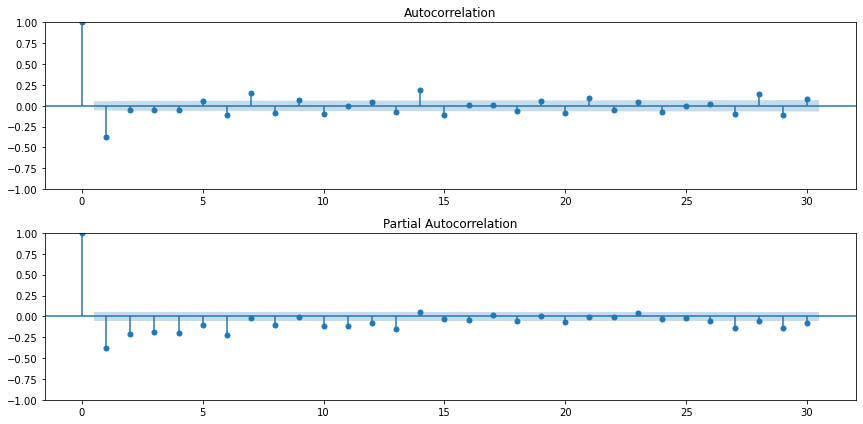

In [22]:
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(transformed_ts, period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(transformed_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Perform ACF and PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(transformed_ts, ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(transformed_ts, ax=plt.gca(), lags=30)
plt.tight_layout()

# Perform Dickey-Fuller test with different lags
best_p_value = 1.0
best_lag = 0
for lag in range(1, 20):
    result = adfuller(transformed_ts, maxlag=lag)
    if result[1] < best_p_value:
        best_p_value = result[1]
        best_lag = lag
print(f"Best p-value: {best_p_value} at lag {best_lag}")

# Perform ADF test with trend and drift terms
result_adf_trend = adfuller(transformed_ts, regression='ct')
if result_adf_trend[1] >= 0.05:
    print('The time series is non-stationary (ADF with trend) since the p-value: %f' % result_adf_trend[1])
else:
    print('The time series is stationary (ADF with trend) since the p-value: %f' % result_adf_trend[1])

# Perform KPSS test with different trend orders
best_p_value_kpss = 1.0
best_trend_order = ''
for trend_order in ['c']:
    result_kpss_trend = kpss(transformed_ts, regression=trend_order)
    if result_kpss_trend[1] < best_p_value_kpss:
        best_p_value_kpss = result_kpss_trend[1]
        best_trend_order = trend_order
print(f"Best p-value (KPSS with {best_trend_order} trend): {best_p_value_kpss}")



After decomposing the time series using the seasonal_decompose function, you can interpret the results of the decomposition to understand the trend, seasonality, and residuals components. Here's a brief explanation of each component:

Trend: The trend component represents the underlying long-term movement or direction of the time series. It captures the overall upward or downward trend over time, ignoring the short-term fluctuations. In the decomposition plot, the trend component is shown in the second subplot. If the trend is increasing, it suggests a positive long-term movement, while a decreasing trend indicates a negative long-term movement.

Seasonality: The seasonality component captures the repeating patterns or cycles that occur within the time series. It represents the regular and predictable fluctuations that occur at specific intervals, such as daily, weekly, or yearly patterns. In the decomposition plot, the seasonality component is shown in the third subplot. It is usually a periodic or oscillating pattern. Seasonality can be interpreted by examining the amplitude and frequency of the cycles.

Residuals: The residuals component represents the remaining variation in the time series after removing the trend and seasonality. It represents the random or unpredictable fluctuations that cannot be explained by the trend or seasonality. In the decomposition plot, the residuals component is shown in the fourth subplot. The residuals should ideally appear as white noise, indicating that the trend and seasonality have been effectively removed. Visually, a white noise graph would look like random fluctuations around zero, without any discernible structure. It should resemble a scatter plot with no apparent trend, cyclicality, or clustering of points. The randomness in the residuals suggests that the trend and seasonality components have been effectively removed from the time series.

By analyzing these components, you can gain insights into the different aspects of your time series. For example, you can assess whether the trend is increasing or decreasing, identify the presence and patterns of seasonality, and evaluate the randomness or noise in the residuals.

It's important to note that the interpretation of the decomposition results may vary depending on the characteristics of your specific time series data and the decomposition model used (e.g., additive or multiplicative). It's recommended to consider additional analysis and domain knowledge to further interpret and understand the components in the context of your data and problem.

Furthermore, I will shift the curve upwards to ensure that there are no negative values. This adjustment is a necessary prerequisite for many analytical techniques and models, ensuring that the data adheres to their specific assumptions and requirements. Also I split the data into train and test, that is test data consists of last 14 days of dataset and the rest of them will be used for traing the proposed models. 

Lastly, I have partitioned the data into training and testing sets. Specifically, the test data encompasses the last 14 days of the dataset, while the remaining portion will be utilized for training the proposed models. This division is crucial for evaluating the model's performance on unseen data and assessing its predictive capabilities.

            Occurrence Count
DATE OCC                    
2020-01-03             435.0
2020-01-04             312.0
2020-01-05             332.0
2020-01-06             455.0
2020-01-07             312.0


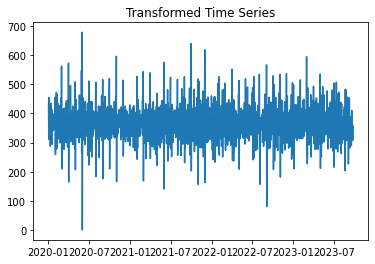

In [23]:
stationary_ts = transformed_ts + abs(transformed_ts.min()) + 1
print(stationary_ts.head())


# Plot the transformed time series
plt.plot(stationary_ts)
plt.title("Transformed Time Series")
plt.show()

# Splitting of data
test_real, train_real= stationary_ts.iloc[-14:,:],  stationary_ts.iloc[:-14,:]

# Time Series Forecasting Techniques

The AutoARIMAModel model starts by importing the necessary libraries, including time, numpy, pandas, matplotlib, and various modules from sklearn and pmdarima for time series forecasting and evaluation.

It defines a class named AutoARIMAModel for encapsulating the AutoARIMA modeling process. The class has the following key methods:

__init__: Initializes the AutoARIMAModel object with maximum autoregressive (AR) and moving average (MA) terms (max_p and max_q).

create_pipeline: Sets up an ARIMA model pipeline using the pmdarima library with hyperparameter tuning.

perform_cross_validation: Performs cross-validation on the training data to evaluate the model's performance using metrics like 
RMSE (Root Mean Squared Error), MAPE (Mean Absolute Percentage Error), and SMAPE (Symmetric Mean Absolute Percentage Error).

make_final_predictions: Trains the AutoARIMA model on the entire training dataset and makes final predictions on the test dataset, returning evaluation metrics and predicted values.

It records the starting time to measure the execution time.

An instance of the AutoARIMAModel class is created with specified hyperparameters (max_p and max_q).

The create_pipeline method is called to set up the AutoARIMA model.

The perform_cross_validation method is called to evaluate the model's performance using cross-validation on the training data.

Final predictions are made using the make_final_predictions method on the entire training dataset and test dataset, and evaluation metrics are computed (RMSE, MAPE, SMAPE).

The execution time is calculated and printed.

A comparison matrix is created, showing the performance metrics and execution time for different forecasting models. In this code, only "AutoARIMA" is populated, and the rest of the rows have NaN values.

A time series plot is created to visualize the true test data and the predicted values using the AutoARIMA model.

Overall, this code provides a structured approach to time series forecasting with AutoARIMA, including model setup, cross-validation for evaluation, and visualization of predictions. It also includes the ability to compare the performance of multiple forecasting models, although in this code, only AutoARIMA is evaluated and compared.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19774.251, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16370.692, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18577.883, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14830.191, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15032.993, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=14767.775, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=14722.395, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=14671.809, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=14660.217, Time=0.16 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=14594.237, Time=0.48 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=1

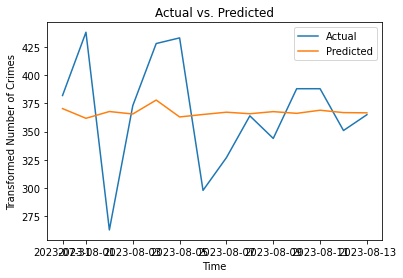

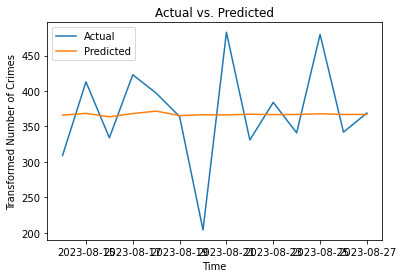

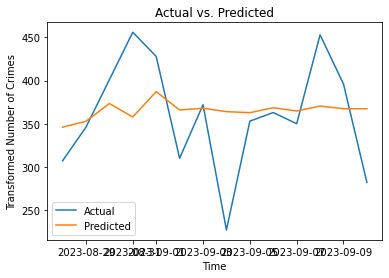

Average RMSE: 58.818643750833964
Average MAPE: 0.13335273867445363
Average SMAPE: 12.424367423166919
RMSE: 31.69097103061047
MAPE: 0.07450891343146805
SMAPE: 7.121841438147569
Execution Time: 15.361
                           RMSE      MAPE     SMAPE  Execution Time (sec.)
AutoARIMA             31.690971  0.074509  7.121841                 15.361
ExponentialSmoothing        NaN       NaN       NaN                    NaN
THETA                       NaN       NaN       NaN                    NaN
Prophet                     NaN       NaN       NaN                    NaN
NBEATS                      NaN       NaN       NaN                    NaN


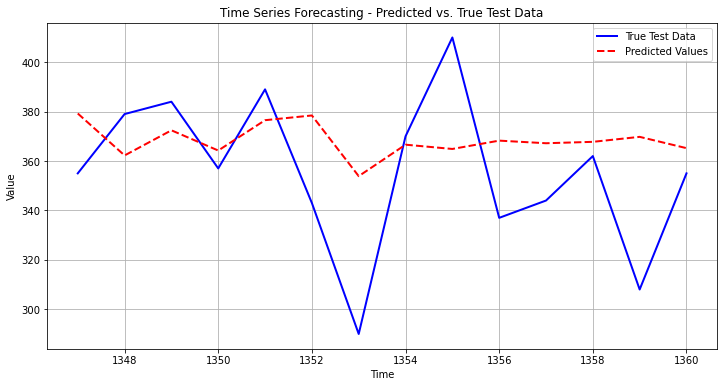

In [24]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, metrics as metr
from pmdarima.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from AutoARIMAModel import AutoARIMAModel

# Initialize the AutoARIMAModel with your training and test data
model = AutoARIMAModel(max_p=10, max_q=10)

# Create the model pipeline
model.create_pipeline()

# Perform cross-validation
model.perform_cross_validation(n_splits=3, test_size=14)

# Make final predictions
final_RMSE, final_MAPE, final_SMAPE, forecasts = model.make_final_predictions()

# Print the evaluation metrics and make use of the forecasts as needed
print(f"Final RMSE: {final_RMSE}")
print(f"Final MAPE: {final_MAPE}")
print(f"Final SMAPE: {final_SMAPE}")

# Visualize the final predictions if needed
plt.figure()
plt.plot(test_real.index, test_real.values, label='Actual')
plt.plot(test_real.index, forecasts, label='Predicted')
plt.title("Actual vs. Predicted")
plt.xlabel("Time")
plt.ylabel("Transformed Number of Crimes")
plt.legend()
plt.show()

# Create a comparison table for models' performance comparison
comparison_matrix = pd.DataFrame(data={"RMSE":final_RMSE, "MAPE":final_MAPE, "SMAPE":final_SMAPE, "Execution Time (sec.)":execution_time},
                                index=["AutoARIMA", "ExponentialSmoothing", 
                                      "THETA", "Prophet", "NBEATS",])
comparison_matrix.iloc[1:,:] = np.nan

print(comparison_matrix)

The folllowing Python script defines a class ExponentialSmoothingModel for performing time series forecasting using the Exponential Smoothing model. Here's a breakdown of the code:

Import necessary libraries at the beginning of the script.

Define a class named ExponentialSmoothingModel with the following methods:

__init__: Initializes the class by accepting training time series data (train_data) as an argument and storing it in the class instance.

train: This method trains the Exponential Smoothing model with hyperparameter tuning and cross-validation. It takes two main arguments:

param_grid: A dictionary containing hyperparameter combinations to search. It includes hyperparameters like trend, seasonal, seasonal periods, and damped.

n_splits: The number of cross-validation splits. It is set to 3 by default.
Within the method:

It initializes variables to track the best RMSE, MAPE, SMAPE, and the best combination of hyperparameters (best_combination).

It sets up a TimeSeriesSplit object for cross-validation.

It iterates through training and validation data using the cross-validation splits.

For each combination of hyperparameters in param_grid, it attempts to fit an Exponential Smoothing model to the training data.

If the fitting fails with a ValueError, it handles specific cases where the seasonal or trend hyperparameters might be causing issues and continues to the next combination.

It computes forecasts (fcst_pred_ES) using the fitted model on the validation data and calculates RMSE, MAPE, and SMAPE.

If the computed RMSE and MAPE are better than the previous best scores, it updates the best scores and records the combination and model.

It prints the best combination of hyperparameters for the specific dataset.

It appends the best RMSE, MAPE, and SMAPE to lists for each iteration.

After iterating through all cross-validation splits and hyperparameter combinations, it prints average RMSE, MAPE, and SMAPE scores.

Finally, it returns the best-fitted Exponential Smoothing model (best_fit_ES) and the best combination of hyperparameters (best_combination).

test: This method is used to test the Exponential Smoothing model on new data. It takes three main arguments:

best_fit_ES: The best-fitted Exponential Smoothing model obtained from the training process.

test_data: Test time series data for evaluation.

Within the method:

It uses the forecast method of the best-fitted model to predict values on the test data.

It calculates RMSE, MAPE, and SMAPE between the predicted values and the actual test data.

It returns these evaluation metrics along with the predicted values.

Best Combination:{'damped': True, 'seasonal': 'add', 'seasonal_periods': 7, 'trend': 'add'}
Best Combination:{'damped': True, 'seasonal': 'add', 'seasonal_periods': 7, 'trend': 'add'}
Best Combination:{'damped': True, 'seasonal': 'add', 'seasonal_periods': 7, 'trend': 'add'}
Average RMSE from cross-validation: 58.69977513636558
Average MAPE from cross-validation: 0.12988116375542255
Average SMAPE from cross-validation: 12.217993262291797
Best Combination:
{'damped': True, 'seasonal': 'add', 'seasonal_periods': 7, 'trend': 'add'}
RMSE: 31.396010972314382
MAPE: 0.07418153452530636
SMAPE: 7.214140321661584
Execution Time: 51.344


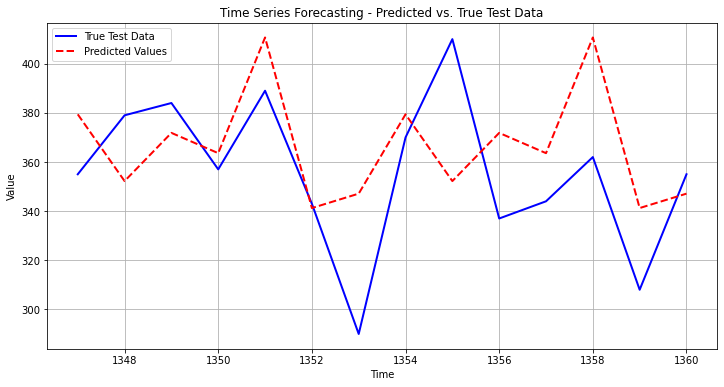

In [25]:
from pmdarima import metrics as metr
from sklearn import metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from ExponentialSmoothingModel import ExponentialSmoothingModel
start_time = time.time()

model = ExponentialSmoothingModel(train_real)

# Grid search parameters
param_grid = {
        'trend': ['add', 'mul', None],
        'seasonal': ['add', 'mul', None],
        'seasonal_periods': [None, 7, 30, 360],
        'damped': [True, False],
    }

# Train the model and get the best fit and combination
best_fit_ES, best_combination = model.train(param_grid, n_splits=3)

# Test the model on the test data
RMSE, MAPE, SMAPE, predicted_values_ExponentialSmoothing = model.test(best_fit_ES, test_real)

# Calculate execution time
execution_time = round((time.time() - start_time),3)

# Print the best combination and their scores
print("Best Combination:")
print(best_combination)
print("RMSE:", RMSE)
print("MAPE:", MAPE)
print("SMAPE:", SMAPE)
print("Execution Time:", execution_time)

# Fill in the comparison matrix
comparison_matrix.loc["ExponentialSmoothing", "RMSE"] = RMSE
comparison_matrix.loc["ExponentialSmoothing", "MAPE"] = MAPE
comparison_matrix.loc["ExponentialSmoothing", "SMAPE"] = SMAPE
comparison_matrix.loc["ExponentialSmoothing", "Execution Time (sec.)"] = execution_time


# Create an array for the x-axis (time index)
time_index = np.arange(len(train_real) + len(test_real))

# Create a larger figure
plt.figure(figsize=(12, 6))

# Plot the true test data
plt.plot(time_index[len(train_real):], test_real.values, label='True Test Data', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(time_index[len(train_real):], predicted_values_ExponentialSmoothing, label='Predicted Values', color='red', linestyle='dashed', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecasting - Predicted vs. True Test Data')   
plt.legend()
plt.grid(True)
plt.show()

This Python script defines a class THETA_ts_forecasting for performing time series forecasting using the Theta model from the Darts library. Here's a breakdown of the code:

Import necessary libraries at the beginning of the script.

Define a class named THETA_ts_forecasting with the following methods:

__init__: Initializes the class with training (train_real) and test (test_real) time series data. It also initializes variables to track the best RMSE, MAPE, SMAPE, and other relevant scores, as well as hyperparameter grid (params_grid) for Theta model hyperparameter tuning.

prepare_data: Prepares the training and test data by converting them into Darts TimeSeries objects.

cross_validate: Performs cross-validation to find the best hyperparameters for the Theta model. It uses a TimeSeriesSplit for cross-validation and iteratively searches for the best combination of hyperparameters by evaluating the Mean Absolute Percentage Error (MAPE) on validation data.

evaluate_on_test_data: Evaluates the Theta model on the test data and calculates RMSE, MAPE, and SMAPE metrics. It uses the best hyperparameters found during cross-validation.

plot_forecast: Plots the forecasted results against the true test data using matplotlib.

The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


Iteration 1: Best MAPE = 11.59, Best Parameters = {'theta': 2, 'seasonality_period': 7, 'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>, 'model_mode': <ModelMode.ADDITIVE: 'additive'>, 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>, 'normalization': True}
Iteration 2: Best MAPE = 11.59, Best Parameters = {'theta': 2, 'seasonality_period': 7, 'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>, 'model_mode': <ModelMode.ADDITIVE: 'additive'>, 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>, 'normalization': True}
Iteration 3: Best MAPE = 11.59, Best Parameters = {'theta': 2, 'seasonality_period': 7, 'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>, 'model_mode': <ModelMode.ADDITIVE: 'additive'>, 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>, 'normalization': True}
Iteration 4: Best MAPE = 11.59, Best Parameters = {'theta': 2, 'seasonality_period': 7, 'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>, 'model_mode': <ModelMode.ADDITIVE: 'additive'>, 'tren

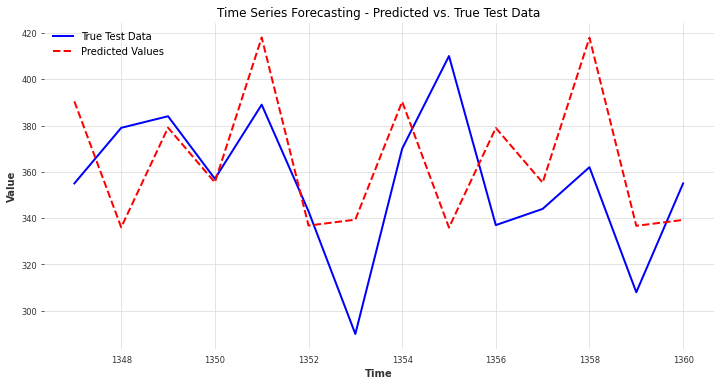

In [26]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models.forecasting.theta import FourTheta
from darts.utils.utils import SeasonalityMode, ModelMode, TrendMode
from darts.utils.model_selection import train_test_split
from darts.metrics.metrics import mape, rmse, smape
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from THETA import THETA_ts_foreacasting

# Start measuring the execution time
start_time = time.time()

# Create an instance of the TimeSeriesForecasting class and provide it with training and test data
forecasting = THETA_ts_foreacasting(train_real, test_real)

# Prepare the time series data (formatting, creating Darts TimeSeries objects)
forecasting.prepare_data()

# Perform cross-validation to optimize hyperparameters
forecasting.cross_validate()

# Evaluate the model on the test data and get RMSE, MAPE, and SMAPE metrics
RMSE, MAPE, SMAPE, predicted_values_THETA = forecasting.evaluate_on_test_data()

# Calculate the total execution time
execution_time = round((time.time() - start_time), 3)

# Fill in the comparison matrix (if available)
# Replace `comparison_matrix` with your actual comparison matrix if needed.
comparison_matrix.loc["THETA", "RMSE"] = RMSE
comparison_matrix.loc["THETA", "MAPE"] = MAPE
comparison_matrix.loc["THETA", "SMAPE"] = SMAPE
comparison_matrix.loc["THETA", "Execution Time (sec.)"] = execution_time

# Print the evaluation metrics and execution time
print("RMSE:", RMSE)
print("MAPE:", MAPE)
print("SMAPE:", SMAPE)
print("Execution Time:", execution_time)

# Plot the forecasted results
forecasting.plot_forecast()



The following Python script defines a class ProphetModel for time series forecasting using the Prophet model from the Darts library and Optuna for hyperparameter tuning. Here's a breakdown of the code:

Import necessary libraries at the beginning of the script, including Darts, Optuna, and relevant metrics.

Define a class named ProphetModel with the following methods:

__init__: Initializes the class with training (train_real) and test (test_real) time series data. It also prepares and formats the data using the prepare_data method.

prepare_data: Prepares and formats the training and test time series data into Darts TimeSeries objects.

create_prophet_model: Creates a Prophet model with specified hyperparameters and holidays.

objective: Defines an objective function for Optuna hyperparameter optimization. It suggests hyperparameters to optimize using Optuna, performs time series cross-validation, and calculates the Mean Absolute Percentage Error (MAPE) for each split.

perform_hyperparameter_tuning: Performs hyperparameter tuning using Optuna to find the best hyperparameters for the Prophet model. It creates an Optuna study and optimizes the objective function.

train_and_evaluate_model: Trains and evaluates the Prophet model with the best hyperparameters found during tuning. It fits the model to the entire training dataset and makes forecasts for the test set. It also calculates RMSE, MAPE, and SMAPE metrics and visualizes the forecasted results.

In [27]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
import optuna
from darts.models import Prophet
from darts.metrics import mape
from darts.utils.statistics import check_seasonality
from darts.metrics.metrics import mape, rmse, smape
import warnings
from ProphetModel import ProphetModel

# Start measuring the execution time
start_time = time.time()

# Create an instance of the ProphetTimeSeriesForecast class with training and test data
prophet_forecast = ProphetModel(train_real, test_real)

# Hyperparameter tuning using Optuna
best_hyperparameters = prophet_forecast.perform_hyperparameter_tuning(n_trials=100)

# Train the model with the best hyperparameters and evaluate it
rmse_value, mape_value, smape_value, predicted_values_Prophet = prophet_forecast.train_and_evaluate_model(best_hyperparameters)

# Calculate the total execution time
execution_time = round((time.time() - start_time), 3)
print("Execution Time:", execution_time)

# Fill in the comparison matrix (if available)
# Replace `comparison_matrix` with your actual comparison matrix if needed.
comparison_matrix.loc["Prophet", "RMSE"] = rmse_value
comparison_matrix.loc["Prophet", "MAPE"] = mape_value
comparison_matrix.loc["Prophet", "SMAPE"] = smape_value
comparison_matrix.loc["Prophet", "Execution Time (sec.)"] = execution_time

[I 2023-10-03 13:54:52,263] A new study created in memory with name: no-name-3a5ac39e-fb8c-4e62-ae3e-73a2ceacc9ba
13:54:52 - cmdstanpy - INFO - Chain [1] start processing
13:54:53 - cmdstanpy - INFO - Chain [1] done processing
13:54:54 - cmdstanpy - INFO - Chain [1] start processing
13:54:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:54,265] Trial 0 finished with value: 0.2722355958418366 and parameters: {'changepoint_prior_scale': 0.6595590327040495, 'seasonality_prior_scale': 15.525539177387294, 'holidays_prior_scale': 0.05330452994338713, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.2722355958418366.
13:54:54 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:54 - cmdstanpy - INFO - Chain [1] done processing
13:54:54 - cmdstanpy - INFO - Chain [1] start processing
13:54:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:55,066] Trial 1 finished with value: 0.27283193335296735 and parameters: {'changepoint_prior_scale': 0.11352374374918218, 'seasonality_prior_scale': 0.448236430738669, 'holidays_prior_scale': 0.036071265078555674, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.2722355958418366.
13:54:55 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:55 - cmdstanpy - INFO - Chain [1] done processing
13:54:55 - cmdstanpy - INFO - Chain [1] start processing
13:54:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:55,822] Trial 2 finished with value: 0.30277943343742586 and parameters: {'changepoint_prior_scale': 0.0011128069078636324, 'seasonality_prior_scale': 0.06842731162307733, 'holidays_prior_scale': 67.87493657673274, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.2722355958418366.
13:54:55 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:56 - cmdstanpy - INFO - Chain [1] done processing
13:54:56 - cmdstanpy - INFO - Chain [1] start processing
13:54:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:56,639] Trial 3 finished with value: 0.2727160563550217 and parameters: {'changepoint_prior_scale': 3.703114736185716, 'seasonality_prior_scale': 3.606862682116297, 'holidays_prior_scale': 0.13933129768158678, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.2722355958418366.
13:54:56 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:56 - cmdstanpy - INFO - Chain [1] done processing
13:54:57 - cmdstanpy - INFO - Chain [1] start processing
13:54:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:57,357] Trial 4 finished with value: 0.27132134403522734 and parameters: {'changepoint_prior_scale': 4.086412213870338, 'seasonality_prior_scale': 2.826811147379593, 'holidays_prior_scale': 0.12968451249045537, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.27132134403522734.
13:54:57 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:57 - cmdstanpy - INFO - Chain [1] done processing
13:54:57 - cmdstanpy - INFO - Chain [1] start processing
13:54:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:58,132] Trial 5 finished with value: 0.2727007400064425 and parameters: {'changepoint_prior_scale': 3.1974970598267345, 'seasonality_prior_scale': 0.7994497577203976, 'holidays_prior_scale': 25.90405806702807, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.27132134403522734.
13:54:58 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:58 - cmdstanpy - INFO - Chain [1] done processing
13:54:58 - cmdstanpy - INFO - Chain [1] start processing
13:54:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:58,933] Trial 6 finished with value: 0.3017727170826865 and parameters: {'changepoint_prior_scale': 0.0013655540964755777, 'seasonality_prior_scale': 0.9575119459996864, 'holidays_prior_scale': 0.37336337343709197, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.27132134403522734.
13:54:59 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:59 - cmdstanpy - INFO - Chain [1] done processing
13:54:59 - cmdstanpy - INFO - Chain [1] start processing
13:54:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:54:59,658] Trial 7 finished with value: 0.3325392906936202 and parameters: {'changepoint_prior_scale': 0.0011487732407956754, 'seasonality_prior_scale': 0.015722702652555036, 'holidays_prior_scale': 9.2169697338758, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.27132134403522734.
13:54:59 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:54:59 - cmdstanpy - INFO - Chain [1] done processing
13:55:00 - cmdstanpy - INFO - Chain [1] start processing
13:55:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:00,395] Trial 8 finished with value: 0.2724387001486377 and parameters: {'changepoint_prior_scale': 1.1427097955031644, 'seasonality_prior_scale': 59.32085864639538, 'holidays_prior_scale': 34.175179292256914, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.27132134403522734.
13:55:00 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:00 - cmdstanpy - INFO - Chain [1] done processing
13:55:00 - cmdstanpy - INFO - Chain [1] start processing
13:55:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:01,171] Trial 9 finished with value: 0.27837429080345966 and parameters: {'changepoint_prior_scale': 0.0060076888997247484, 'seasonality_prior_scale': 52.09028410104284, 'holidays_prior_scale': 41.04372355666763, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.27132134403522734.


Trial 2 has Empty dataset


13:55:01 - cmdstanpy - INFO - Chain [1] start processing
13:55:01 - cmdstanpy - INFO - Chain [1] done processing
13:55:01 - cmdstanpy - INFO - Chain [1] start processing
13:55:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:02,188] Trial 10 finished with value: 0.2712066362660538 and parameters: {'changepoint_prior_scale': 8.728734702469138, 'seasonality_prior_scale': 6.518309070048459, 'holidays_prior_scale': 0.015640862633117356, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.2712066362660538.


Trial 2 has Empty dataset


13:55:02 - cmdstanpy - INFO - Chain [1] start processing
13:55:02 - cmdstanpy - INFO - Chain [1] done processing
13:55:02 - cmdstanpy - INFO - Chain [1] start processing
13:55:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:03,078] Trial 11 finished with value: 0.27123658693696195 and parameters: {'changepoint_prior_scale': 8.711500170493824, 'seasonality_prior_scale': 5.27423976670614, 'holidays_prior_scale': 0.014059128974156345, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.2712066362660538.
13:55:03 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:03 - cmdstanpy - INFO - Chain [1] done processing
13:55:03 - cmdstanpy - INFO - Chain [1] start processing
13:55:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:04,066] Trial 12 finished with value: 0.2711754668835725 and parameters: {'changepoint_prior_scale': 9.23957997293082, 'seasonality_prior_scale': 8.347407105468847, 'holidays_prior_scale': 0.010695174401566952, 'seasonality_mode': 'additive'}. Best is trial 12 with value: 0.2711754668835725.
13:55:04 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:04 - cmdstanpy - INFO - Chain [1] done processing
13:55:04 - cmdstanpy - INFO - Chain [1] start processing
13:55:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:04,861] Trial 13 finished with value: 0.27251392737921487 and parameters: {'changepoint_prior_scale': 0.6256295298703678, 'seasonality_prior_scale': 14.638388310849328, 'holidays_prior_scale': 0.012960971261786964, 'seasonality_mode': 'additive'}. Best is trial 12 with value: 0.2711754668835725.
13:55:05 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:05 - cmdstanpy - INFO - Chain [1] done processing
13:55:05 - cmdstanpy - INFO - Chain [1] start processing
13:55:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:05,668] Trial 14 finished with value: 0.27128332935043653 and parameters: {'changepoint_prior_scale': 7.028403184250489, 'seasonality_prior_scale': 10.346583573798135, 'holidays_prior_scale': 1.6063926072838315, 'seasonality_mode': 'additive'}. Best is trial 12 with value: 0.2711754668835725.
13:55:05 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:05 - cmdstanpy - INFO - Chain [1] done processing
13:55:06 - cmdstanpy - INFO - Chain [1] start processing
13:55:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:06,502] Trial 15 finished with value: 0.2711683086795017 and parameters: {'changepoint_prior_scale': 9.056367254546187, 'seasonality_prior_scale': 38.82339406530919, 'holidays_prior_scale': 0.010518398260664604, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:06 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:06 - cmdstanpy - INFO - Chain [1] done processing
13:55:07 - cmdstanpy - INFO - Chain [1] start processing
13:55:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:07,333] Trial 16 finished with value: 0.27209440884211133 and parameters: {'changepoint_prior_scale': 1.2648630764648574, 'seasonality_prior_scale': 43.40162030586702, 'holidays_prior_scale': 0.011190283341584811, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:07 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:07 - cmdstanpy - INFO - Chain [1] done processing
13:55:07 - cmdstanpy - INFO - Chain [1] start processing
13:55:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:08,151] Trial 17 finished with value: 0.2723553609360385 and parameters: {'changepoint_prior_scale': 0.24079713259418944, 'seasonality_prior_scale': 78.65930630170338, 'holidays_prior_scale': 0.04892409855195501, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:08 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:08 - cmdstanpy - INFO - Chain [1] done processing
13:55:08 - cmdstanpy - INFO - Chain [1] start processing
13:55:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:08,972] Trial 18 finished with value: 0.27164071661839084 and parameters: {'changepoint_prior_scale': 1.8270179729900113, 'seasonality_prior_scale': 24.72762501664165, 'holidays_prior_scale': 1.3104970181752393, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.


Trial 2 has Empty dataset


13:55:09 - cmdstanpy - INFO - Chain [1] start processing
13:55:09 - cmdstanpy - INFO - Chain [1] done processing
13:55:09 - cmdstanpy - INFO - Chain [1] start processing
13:55:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:09,785] Trial 19 finished with value: 0.27285156730848403 and parameters: {'changepoint_prior_scale': 0.0325541123995965, 'seasonality_prior_scale': 24.598141665925205, 'holidays_prior_scale': 0.03340746494407395, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:09 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:10 - cmdstanpy - INFO - Chain [1] done processing
13:55:10 - cmdstanpy - INFO - Chain [1] start processing
13:55:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:10,602] Trial 20 finished with value: 0.2713696279260602 and parameters: {'changepoint_prior_scale': 3.1399408689259194, 'seasonality_prior_scale': 94.57741207451893, 'holidays_prior_scale': 0.12307555741158151, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:10 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:10 - cmdstanpy - INFO - Chain [1] done processing
13:55:11 - cmdstanpy - INFO - Chain [1] start processing
13:55:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:11,412] Trial 21 finished with value: 0.27129516717365015 and parameters: {'changepoint_prior_scale': 7.321695709196629, 'seasonality_prior_scale': 5.947512163549406, 'holidays_prior_scale': 0.010969940908905313, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:11 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:11 - cmdstanpy - INFO - Chain [1] done processing
13:55:11 - cmdstanpy - INFO - Chain [1] start processing
13:55:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:12,203] Trial 22 finished with value: 0.2713002902475119 and parameters: {'changepoint_prior_scale': 9.354067983396936, 'seasonality_prior_scale': 8.429106863969375, 'holidays_prior_scale': 0.02245084213941892, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:12 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:12 - cmdstanpy - INFO - Chain [1] done processing
13:55:12 - cmdstanpy - INFO - Chain [1] start processing
13:55:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:13,016] Trial 23 finished with value: 0.2712530223037757 and parameters: {'changepoint_prior_scale': 9.506317362153467, 'seasonality_prior_scale': 23.077662153739436, 'holidays_prior_scale': 0.02187636660450644, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:13 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:13 - cmdstanpy - INFO - Chain [1] done processing
13:55:13 - cmdstanpy - INFO - Chain [1] start processing
13:55:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:13,802] Trial 24 finished with value: 0.2716707771941894 and parameters: {'changepoint_prior_scale': 1.839135138456601, 'seasonality_prior_scale': 2.379207650445277, 'holidays_prior_scale': 0.060309867259140795, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:13 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:14 - cmdstanpy - INFO - Chain [1] done processing
13:55:14 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:14,595] Trial 25 finished with value: 0.27128245177259847 and parameters: {'changepoint_prior_scale': 3.4485656771563717, 'seasonality_prior_scale': 6.988037723352998, 'holidays_prior_scale': 0.023131654212379518, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:14 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:14 - cmdstanpy - INFO - Chain [1] done processing
13:55:15 - cmdstanpy - INFO - Chain [1] start processing
13:55:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:15,433] Trial 26 finished with value: 0.27239951014258557 and parameters: {'changepoint_prior_scale': 0.5390861073688769, 'seasonality_prior_scale': 32.36314419475527, 'holidays_prior_scale': 0.011288669508352962, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:15 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:15 - cmdstanpy - INFO - Chain [1] done processing
13:55:15 - cmdstanpy - INFO - Chain [1] start processing
13:55:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:16,233] Trial 27 finished with value: 0.27126665909278624 and parameters: {'changepoint_prior_scale': 4.202073783661138, 'seasonality_prior_scale': 14.260652397426567, 'holidays_prior_scale': 0.07894041321079687, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.


Trial 2 has Empty dataset


13:55:16 - cmdstanpy - INFO - Chain [1] start processing
13:55:16 - cmdstanpy - INFO - Chain [1] done processing
13:55:16 - cmdstanpy - INFO - Chain [1] start processing
13:55:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:17,063] Trial 28 finished with value: 0.27157339222064436 and parameters: {'changepoint_prior_scale': 1.906754956688426, 'seasonality_prior_scale': 2.452903408995654, 'holidays_prior_scale': 0.02939987556600546, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:17 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:17 - cmdstanpy - INFO - Chain [1] done processing
13:55:17 - cmdstanpy - INFO - Chain [1] start processing
13:55:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:17,830] Trial 29 finished with value: 0.2723949727156926 and parameters: {'changepoint_prior_scale': 0.8796827018497252, 'seasonality_prior_scale': 13.992965171314653, 'holidays_prior_scale': 0.05153027227211504, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:18 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:18 - cmdstanpy - INFO - Chain [1] done processing
13:55:18 - cmdstanpy - INFO - Chain [1] start processing
13:55:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:18,596] Trial 30 finished with value: 0.27244686275102337 and parameters: {'changepoint_prior_scale': 0.3678657617619843, 'seasonality_prior_scale': 37.70720077601304, 'holidays_prior_scale': 0.26358794445107236, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:18 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:18 - cmdstanpy - INFO - Chain [1] done processing
13:55:19 - cmdstanpy - INFO - Chain [1] start processing
13:55:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:19,395] Trial 31 finished with value: 0.2711935279741208 and parameters: {'changepoint_prior_scale': 9.27639958755109, 'seasonality_prior_scale': 5.578516338072483, 'holidays_prior_scale': 0.017947425450897996, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:19 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:19 - cmdstanpy - INFO - Chain [1] done processing
13:55:19 - cmdstanpy - INFO - Chain [1] start processing
13:55:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:20,163] Trial 32 finished with value: 0.2712779372350894 and parameters: {'changepoint_prior_scale': 5.755567302939387, 'seasonality_prior_scale': 9.31346697981944, 'holidays_prior_scale': 0.021848775232413565, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:20 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:20 - cmdstanpy - INFO - Chain [1] done processing
13:55:20 - cmdstanpy - INFO - Chain [1] start processing
13:55:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:20,930] Trial 33 finished with value: 0.2712947995426514 and parameters: {'changepoint_prior_scale': 5.08733301950061, 'seasonality_prior_scale': 1.5115714325406393, 'holidays_prior_scale': 0.035458682911912544, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:21 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:21 - cmdstanpy - INFO - Chain [1] done processing
13:55:21 - cmdstanpy - INFO - Chain [1] start processing
13:55:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:21,706] Trial 34 finished with value: 0.2714059261160555 and parameters: {'changepoint_prior_scale': 2.1500015396092134, 'seasonality_prior_scale': 4.817408747954491, 'holidays_prior_scale': 0.017776441945163497, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:21 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:21 - cmdstanpy - INFO - Chain [1] done processing
13:55:22 - cmdstanpy - INFO - Chain [1] start processing
13:55:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:22,513] Trial 35 finished with value: 0.2728141698060229 and parameters: {'changepoint_prior_scale': 9.816991553363104, 'seasonality_prior_scale': 3.6022767711674635, 'holidays_prior_scale': 0.031548301862781535, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2711683086795017.
13:55:22 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:22 - cmdstanpy - INFO - Chain [1] done processing
13:55:23 - cmdstanpy - INFO - Chain [1] start processing
13:55:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:23,315] Trial 36 finished with value: 0.2713221162552682 and parameters: {'changepoint_prior_scale': 5.186580833160656, 'seasonality_prior_scale': 0.45358008007780043, 'holidays_prior_scale': 0.010145405901972248, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.


Trial 2 has Empty dataset


13:55:23 - cmdstanpy - INFO - Chain [1] start processing
13:55:23 - cmdstanpy - INFO - Chain [1] done processing
13:55:23 - cmdstanpy - INFO - Chain [1] start processing
13:55:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:24,133] Trial 37 finished with value: 0.2712557522137814 and parameters: {'changepoint_prior_scale': 5.154655474233361, 'seasonality_prior_scale': 19.058831860885228, 'holidays_prior_scale': 0.07602813230580995, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:24 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:24 - cmdstanpy - INFO - Chain [1] done processing
13:55:24 - cmdstanpy - INFO - Chain [1] start processing
13:55:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:24,912] Trial 38 finished with value: 0.27265800525677 and parameters: {'changepoint_prior_scale': 2.7489260043738915, 'seasonality_prior_scale': 1.697025783247258, 'holidays_prior_scale': 0.01842249201625849, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2711683086795017.
13:55:25 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:25 - cmdstanpy - INFO - Chain [1] done processing
13:55:25 - cmdstanpy - INFO - Chain [1] start processing
13:55:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:25,716] Trial 39 finished with value: 0.27138337651146005 and parameters: {'changepoint_prior_scale': 3.069276943731241, 'seasonality_prior_scale': 5.028175317782575, 'holidays_prior_scale': 0.049090199622299914, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:25 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:25 - cmdstanpy - INFO - Chain [1] done processing
13:55:26 - cmdstanpy - INFO - Chain [1] start processing
13:55:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:26,514] Trial 40 finished with value: 0.27244577335763365 and parameters: {'changepoint_prior_scale': 1.2446233759432406, 'seasonality_prior_scale': 10.969197494832848, 'holidays_prior_scale': 0.01643319167916707, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2711683086795017.
13:55:26 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:26 - cmdstanpy - INFO - Chain [1] done processing
13:55:27 - cmdstanpy - INFO - Chain [1] start processing
13:55:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:27,330] Trial 41 finished with value: 0.2711947299020777 and parameters: {'changepoint_prior_scale': 9.540515080478919, 'seasonality_prior_scale': 3.721824058911327, 'holidays_prior_scale': 0.010044217368523083, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:27 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:27 - cmdstanpy - INFO - Chain [1] done processing
13:55:27 - cmdstanpy - INFO - Chain [1] start processing
13:55:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:28,185] Trial 42 finished with value: 0.27124442306732843 and parameters: {'changepoint_prior_scale': 5.898710756961257, 'seasonality_prior_scale': 3.335554361092535, 'holidays_prior_scale': 0.016219600457675166, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:28 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:28 - cmdstanpy - INFO - Chain [1] done processing
13:55:28 - cmdstanpy - INFO - Chain [1] start processing
13:55:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:29,006] Trial 43 finished with value: 0.2713039537557136 and parameters: {'changepoint_prior_scale': 4.3780278676553435, 'seasonality_prior_scale': 7.499338841386131, 'holidays_prior_scale': 0.010359636470291497, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:29 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:29 - cmdstanpy - INFO - Chain [1] done processing
13:55:29 - cmdstanpy - INFO - Chain [1] start processing
13:55:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:29,856] Trial 44 finished with value: 0.27126107146469447 and parameters: {'changepoint_prior_scale': 7.14502343012647, 'seasonality_prior_scale': 4.379554317136833, 'holidays_prior_scale': 0.03466750397728273, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:30 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:30 - cmdstanpy - INFO - Chain [1] done processing
13:55:30 - cmdstanpy - INFO - Chain [1] start processing
13:55:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:30,689] Trial 45 finished with value: 0.2712089281648288 and parameters: {'changepoint_prior_scale': 9.231538566162827, 'seasonality_prior_scale': 16.711172454804796, 'holidays_prior_scale': 0.016702176626799, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.


Trial 2 has Empty dataset


13:55:30 - cmdstanpy - INFO - Chain [1] start processing
13:55:30 - cmdstanpy - INFO - Chain [1] done processing
13:55:31 - cmdstanpy - INFO - Chain [1] start processing
13:55:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:31,514] Trial 46 finished with value: 0.27264492152643693 and parameters: {'changepoint_prior_scale': 2.719031829010894, 'seasonality_prior_scale': 1.5581857938112178, 'holidays_prior_scale': 0.029163866298707746, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2711683086795017.
13:55:31 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:31 - cmdstanpy - INFO - Chain [1] done processing
13:55:32 - cmdstanpy - INFO - Chain [1] start processing
13:55:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:32,479] Trial 47 finished with value: 0.2713399096170447 and parameters: {'changepoint_prior_scale': 4.209283411638295, 'seasonality_prior_scale': 58.959024120164564, 'holidays_prior_scale': 0.015543240065881526, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:32 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:32 - cmdstanpy - INFO - Chain [1] done processing
13:55:33 - cmdstanpy - INFO - Chain [1] start processing
13:55:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:33,267] Trial 48 finished with value: 0.2712980801149487 and parameters: {'changepoint_prior_scale': 6.378185436769999, 'seasonality_prior_scale': 6.603562482107153, 'holidays_prior_scale': 0.09957213455515962, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2711683086795017.
13:55:33 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:33 - cmdstanpy - INFO - Chain [1] done processing
13:55:33 - cmdstanpy - INFO - Chain [1] start processing
13:55:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:34,069] Trial 49 finished with value: 0.27116587456664853 and parameters: {'changepoint_prior_scale': 9.926152075869952, 'seasonality_prior_scale': 32.03400077948856, 'holidays_prior_scale': 0.04644743683512511, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.


Trial 2 has Empty dataset


13:55:34 - cmdstanpy - INFO - Chain [1] start processing
13:55:34 - cmdstanpy - INFO - Chain [1] done processing
13:55:34 - cmdstanpy - INFO - Chain [1] start processing
13:55:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:34,899] Trial 50 finished with value: 0.27150375373926383 and parameters: {'changepoint_prior_scale': 2.3588936458466088, 'seasonality_prior_scale': 33.519693332164714, 'holidays_prior_scale': 0.045098025236307994, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:35 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:35 - cmdstanpy - INFO - Chain [1] done processing
13:55:35 - cmdstanpy - INFO - Chain [1] start processing
13:55:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:35,701] Trial 51 finished with value: 0.2712332131146755 and parameters: {'changepoint_prior_scale': 9.50620438227935, 'seasonality_prior_scale': 11.608305190261282, 'holidays_prior_scale': 0.010006182846059582, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:35 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:35 - cmdstanpy - INFO - Chain [1] done processing
13:55:36 - cmdstanpy - INFO - Chain [1] start processing
13:55:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:36,502] Trial 52 finished with value: 0.2712997586420738 and parameters: {'changepoint_prior_scale': 6.495011180803364, 'seasonality_prior_scale': 63.19876694238654, 'holidays_prior_scale': 0.024927562579011624, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:36 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:36 - cmdstanpy - INFO - Chain [1] done processing
13:55:37 - cmdstanpy - INFO - Chain [1] start processing
13:55:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:37,314] Trial 53 finished with value: 0.2713499293316678 and parameters: {'changepoint_prior_scale': 3.8443232335162003, 'seasonality_prior_scale': 23.29088180275629, 'holidays_prior_scale': 0.015475190796357287, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:37 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:37 - cmdstanpy - INFO - Chain [1] done processing
13:55:37 - cmdstanpy - INFO - Chain [1] start processing
13:55:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:38,119] Trial 54 finished with value: 0.2712193541792931 and parameters: {'changepoint_prior_scale': 6.461493869333545, 'seasonality_prior_scale': 9.555851835986207, 'holidays_prior_scale': 0.014188474736544197, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:38 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:38 - cmdstanpy - INFO - Chain [1] done processing
13:55:38 - cmdstanpy - INFO - Chain [1] start processing
13:55:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:38,929] Trial 55 finished with value: 0.2717244993416363 and parameters: {'changepoint_prior_scale': 1.6287057212806197, 'seasonality_prior_scale': 95.84633311984771, 'holidays_prior_scale': 0.02350540409443678, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:39 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:39 - cmdstanpy - INFO - Chain [1] done processing
13:55:39 - cmdstanpy - INFO - Chain [1] start processing
13:55:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:39,732] Trial 56 finished with value: 0.2713846089883047 and parameters: {'changepoint_prior_scale': 3.695816031619751, 'seasonality_prior_scale': 49.4976819983024, 'holidays_prior_scale': 0.035437149582341454, 'seasonality_mode': 'additive'}. Best is trial 49 with value: 0.27116587456664853.
13:55:39 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:40 - cmdstanpy - INFO - Chain [1] done processing
13:55:40 - cmdstanpy - INFO - Chain [1] start processing
13:55:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:40,552] Trial 57 finished with value: 0.2727378459328694 and parameters: {'changepoint_prior_scale': 7.608840780933853, 'seasonality_prior_scale': 15.24154539438943, 'holidays_prior_scale': 0.014214447556661285, 'seasonality_mode': 'multiplicative'}. Best is trial 49 with value: 0.27116587456664853.


Trial 2 has Empty dataset


13:55:40 - cmdstanpy - INFO - Chain [1] start processing
13:55:40 - cmdstanpy - INFO - Chain [1] done processing
13:55:41 - cmdstanpy - INFO - Chain [1] start processing
13:55:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:41,335] Trial 58 finished with value: 0.2711096346370301 and parameters: {'changepoint_prior_scale': 9.946832516431025, 'seasonality_prior_scale': 30.054023282478664, 'holidays_prior_scale': 0.06529516977912134, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:41 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:41 - cmdstanpy - INFO - Chain [1] done processing
13:55:41 - cmdstanpy - INFO - Chain [1] start processing
13:55:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:42,119] Trial 59 finished with value: 0.2711847686948059 and parameters: {'changepoint_prior_scale': 2.977042889404993, 'seasonality_prior_scale': 27.840628398052463, 'holidays_prior_scale': 0.05840069942095505, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:42 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:42 - cmdstanpy - INFO - Chain [1] done processing
13:55:42 - cmdstanpy - INFO - Chain [1] start processing
13:55:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:42,885] Trial 60 finished with value: 0.2713898518831338 and parameters: {'changepoint_prior_scale': 2.7356960137813418, 'seasonality_prior_scale': 29.77152176980777, 'holidays_prior_scale': 0.07002691474515811, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:43 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:43 - cmdstanpy - INFO - Chain [1] done processing
13:55:43 - cmdstanpy - INFO - Chain [1] start processing
13:55:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:43,716] Trial 61 finished with value: 0.2711482362404066 and parameters: {'changepoint_prior_scale': 9.642972793998055, 'seasonality_prior_scale': 38.02228298548562, 'holidays_prior_scale': 0.044834678123317026, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.


Trial 2 has Empty dataset


13:55:43 - cmdstanpy - INFO - Chain [1] start processing
13:55:43 - cmdstanpy - INFO - Chain [1] done processing
13:55:44 - cmdstanpy - INFO - Chain [1] start processing
13:55:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:44,572] Trial 62 finished with value: 0.2712596286693174 and parameters: {'changepoint_prior_scale': 5.576387065573195, 'seasonality_prior_scale': 46.70948672111226, 'holidays_prior_scale': 0.15488240429600567, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:44 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:44 - cmdstanpy - INFO - Chain [1] done processing
13:55:45 - cmdstanpy - INFO - Chain [1] start processing
13:55:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:45,401] Trial 63 finished with value: 0.2712704330947144 and parameters: {'changepoint_prior_scale': 7.20960393190584, 'seasonality_prior_scale': 20.821294090773424, 'holidays_prior_scale': 0.04543842670236582, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:45 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:45 - cmdstanpy - INFO - Chain [1] done processing
13:55:45 - cmdstanpy - INFO - Chain [1] start processing
13:55:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:46,199] Trial 64 finished with value: 0.27135237251849953 and parameters: {'changepoint_prior_scale': 4.283407910339966, 'seasonality_prior_scale': 35.16065254308662, 'holidays_prior_scale': 0.02600432950106862, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:46 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:46 - cmdstanpy - INFO - Chain [1] done processing
13:55:46 - cmdstanpy - INFO - Chain [1] start processing
13:55:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:47,050] Trial 65 finished with value: 0.2711218579010775 and parameters: {'changepoint_prior_scale': 9.735409362508877, 'seasonality_prior_scale': 68.50538496301704, 'holidays_prior_scale': 0.06078130393695194, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:47 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:47 - cmdstanpy - INFO - Chain [1] done processing
13:55:47 - cmdstanpy - INFO - Chain [1] start processing
13:55:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:47,853] Trial 66 finished with value: 0.27129472686086636 and parameters: {'changepoint_prior_scale': 3.3714584218777657, 'seasonality_prior_scale': 70.9085711371089, 'holidays_prior_scale': 0.1015739351637531, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:48 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:48 - cmdstanpy - INFO - Chain [1] done processing
13:55:48 - cmdstanpy - INFO - Chain [1] start processing
13:55:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:48,668] Trial 67 finished with value: 0.2713286171104604 and parameters: {'changepoint_prior_scale': 4.877226347478437, 'seasonality_prior_scale': 45.44409626031613, 'holidays_prior_scale': 0.05784653011565424, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:48 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:48 - cmdstanpy - INFO - Chain [1] done processing
13:55:49 - cmdstanpy - INFO - Chain [1] start processing
13:55:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:49,485] Trial 68 finished with value: 0.27123503037567487 and parameters: {'changepoint_prior_scale': 7.471778610321193, 'seasonality_prior_scale': 26.653763570164486, 'holidays_prior_scale': 0.1705990784836988, 'seasonality_mode': 'additive'}. Best is trial 58 with value: 0.2711096346370301.
13:55:49 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:49 - cmdstanpy - INFO - Chain [1] done processing
13:55:50 - cmdstanpy - INFO - Chain [1] start processing
13:55:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:50,319] Trial 69 finished with value: 0.2710917670013496 and parameters: {'changepoint_prior_scale': 9.930385909084361, 'seasonality_prior_scale': 74.45101461162706, 'holidays_prior_scale': 0.06434223457113367, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:55:50 - cmdstanpy - INFO - Chain [1] start processing
13:55:50 - cmdstanpy - INFO - Chain [1] done processing
13:55:50 - cmdstanpy - INFO - Chain [1] start processing
13:55:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:51,153] Trial 70 finished with value: 0.27126670191811453 and parameters: {'changepoint_prior_scale': 7.366191244185197, 'seasonality_prior_scale': 80.97818565286398, 'holidays_prior_scale': 0.04138140663337955, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:51 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:51 - cmdstanpy - INFO - Chain [1] done processing
13:55:51 - cmdstanpy - INFO - Chain [1] start processing
13:55:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:52,020] Trial 71 finished with value: 0.27130637593060347 and parameters: {'changepoint_prior_scale': 5.2909059434767585, 'seasonality_prior_scale': 60.807225405862944, 'holidays_prior_scale': 0.06174671012796475, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:55:52 - cmdstanpy - INFO - Chain [1] start processing
13:55:52 - cmdstanpy - INFO - Chain [1] done processing
13:55:52 - cmdstanpy - INFO - Chain [1] start processing
13:55:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:52,830] Trial 72 finished with value: 0.27115643286213764 and parameters: {'changepoint_prior_scale': 9.844637853926347, 'seasonality_prior_scale': 44.303849053759784, 'holidays_prior_scale': 0.0884199741572429, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:53 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:53 - cmdstanpy - INFO - Chain [1] done processing
13:55:53 - cmdstanpy - INFO - Chain [1] start processing
13:55:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:53,613] Trial 73 finished with value: 0.2710949726969252 and parameters: {'changepoint_prior_scale': 9.54209328134978, 'seasonality_prior_scale': 38.00367427681622, 'holidays_prior_scale': 0.08417527420282543, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:53 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:53 - cmdstanpy - INFO - Chain [1] done processing
13:55:54 - cmdstanpy - INFO - Chain [1] start processing
13:55:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:54,413] Trial 74 finished with value: 0.2712391595863346 and parameters: {'changepoint_prior_scale': 7.6477804604799005, 'seasonality_prior_scale': 39.903206841580534, 'holidays_prior_scale': 0.08680161871764729, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:54 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:54 - cmdstanpy - INFO - Chain [1] done processing
13:55:54 - cmdstanpy - INFO - Chain [1] start processing
13:55:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:55,198] Trial 75 finished with value: 0.27123989747534094 and parameters: {'changepoint_prior_scale': 9.990492485046397, 'seasonality_prior_scale': 76.57938594817611, 'holidays_prior_scale': 0.1271085023266612, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:55 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:55 - cmdstanpy - INFO - Chain [1] done processing
13:55:55 - cmdstanpy - INFO - Chain [1] start processing
13:55:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:55,980] Trial 76 finished with value: 0.27127732883385924 and parameters: {'changepoint_prior_scale': 5.7085784692322195, 'seasonality_prior_scale': 99.62457011766786, 'holidays_prior_scale': 0.07798197194800817, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:56 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:56 - cmdstanpy - INFO - Chain [1] done processing
13:55:56 - cmdstanpy - INFO - Chain [1] start processing
13:55:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:56,763] Trial 77 finished with value: 0.2727732768614626 and parameters: {'changepoint_prior_scale': 4.345407690063333, 'seasonality_prior_scale': 52.82280086386296, 'holidays_prior_scale': 0.20525289773773925, 'seasonality_mode': 'multiplicative'}. Best is trial 69 with value: 0.2710917670013496.
13:55:56 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:57 - cmdstanpy - INFO - Chain [1] done processing
13:55:57 - cmdstanpy - INFO - Chain [1] start processing
13:55:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:57,546] Trial 78 finished with value: 0.27126195060895963 and parameters: {'changepoint_prior_scale': 7.836858427790052, 'seasonality_prior_scale': 41.661404553912085, 'holidays_prior_scale': 0.11334542140494756, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:57 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:57 - cmdstanpy - INFO - Chain [1] done processing
13:55:58 - cmdstanpy - INFO - Chain [1] start processing
13:55:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:58,329] Trial 79 finished with value: 0.27127183775912 and parameters: {'changepoint_prior_scale': 3.614780617354314, 'seasonality_prior_scale': 19.38020434045867, 'holidays_prior_scale': 0.07745152269908108, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:58 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:58 - cmdstanpy - INFO - Chain [1] done processing
13:55:58 - cmdstanpy - INFO - Chain [1] start processing
13:55:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:59,130] Trial 80 finished with value: 0.2712367664318876 and parameters: {'changepoint_prior_scale': 9.890048227295553, 'seasonality_prior_scale': 35.63069352224089, 'holidays_prior_scale': 0.040093982430790945, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:55:59 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:55:59 - cmdstanpy - INFO - Chain [1] done processing
13:55:59 - cmdstanpy - INFO - Chain [1] start processing
13:55:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:55:59,913] Trial 81 finished with value: 0.27132009286788633 and parameters: {'changepoint_prior_scale': 6.358548689443732, 'seasonality_prior_scale': 67.4136937685325, 'holidays_prior_scale': 0.10135851248566308, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:00 - cmdstanpy - INFO - Chain [1] start processing
13:56:00 - cmdstanpy - INFO - Chain [1] done processing
13:56:00 - cmdstanpy - INFO - Chain [1] start processing
13:56:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:00,713] Trial 82 finished with value: 0.27124643515684954 and parameters: {'changepoint_prior_scale': 9.93974629262601, 'seasonality_prior_scale': 29.790152573674124, 'holidays_prior_scale': 0.0520068136383302, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:00 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:00 - cmdstanpy - INFO - Chain [1] done processing
13:56:01 - cmdstanpy - INFO - Chain [1] start processing
13:56:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:01,496] Trial 83 finished with value: 0.2712871090607545 and parameters: {'changepoint_prior_scale': 5.006784707921444, 'seasonality_prior_scale': 49.87253382627823, 'holidays_prior_scale': 0.03283403921839794, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:01 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:01 - cmdstanpy - INFO - Chain [1] done processing
13:56:02 - cmdstanpy - INFO - Chain [1] start processing
13:56:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:02,297] Trial 84 finished with value: 0.2713290184118774 and parameters: {'changepoint_prior_scale': 7.825367663906522, 'seasonality_prior_scale': 24.436624209585442, 'holidays_prior_scale': 0.06392859944570992, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:02 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:02 - cmdstanpy - INFO - Chain [1] done processing
13:56:02 - cmdstanpy - INFO - Chain [1] start processing
13:56:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:03,080] Trial 85 finished with value: 0.2713118649515204 and parameters: {'changepoint_prior_scale': 5.909319376334017, 'seasonality_prior_scale': 37.60395607314254, 'holidays_prior_scale': 0.02017051632679287, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:03 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:03 - cmdstanpy - INFO - Chain [1] done processing
13:56:03 - cmdstanpy - INFO - Chain [1] start processing
13:56:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:03,880] Trial 86 finished with value: 0.27129681521588983 and parameters: {'changepoint_prior_scale': 8.11581847468478, 'seasonality_prior_scale': 56.232188589564615, 'holidays_prior_scale': 0.02878380366734834, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:04 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:04 - cmdstanpy - INFO - Chain [1] done processing
13:56:04 - cmdstanpy - INFO - Chain [1] start processing
13:56:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:04,646] Trial 87 finished with value: 0.27121021327350714 and parameters: {'changepoint_prior_scale': 4.4733173961473485, 'seasonality_prior_scale': 19.157510300247246, 'holidays_prior_scale': 0.12537531221260326, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:04 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:04 - cmdstanpy - INFO - Chain [1] done processing
13:56:05 - cmdstanpy - INFO - Chain [1] start processing
13:56:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:05,413] Trial 88 finished with value: 0.27268518051277013 and parameters: {'changepoint_prior_scale': 5.943912508828664, 'seasonality_prior_scale': 81.16520677324081, 'holidays_prior_scale': 0.09347652266668259, 'seasonality_mode': 'multiplicative'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:05 - cmdstanpy - INFO - Chain [1] start processing
13:56:05 - cmdstanpy - INFO - Chain [1] done processing
13:56:06 - cmdstanpy - INFO - Chain [1] start processing
13:56:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:06,262] Trial 89 finished with value: 0.271266525920729 and parameters: {'changepoint_prior_scale': 8.153371194772154, 'seasonality_prior_scale': 12.37317319838266, 'holidays_prior_scale': 0.04610594158305005, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:06 - cmdstanpy - INFO - Chain [1] start processing
13:56:06 - cmdstanpy - INFO - Chain [1] done processing
13:56:06 - cmdstanpy - INFO - Chain [1] start processing
13:56:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:07,079] Trial 90 finished with value: 0.2713596190010181 and parameters: {'changepoint_prior_scale': 3.909408928436912, 'seasonality_prior_scale': 42.69439162054907, 'holidays_prior_scale': 0.03747149107640452, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:07 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:07 - cmdstanpy - INFO - Chain [1] done processing
13:56:07 - cmdstanpy - INFO - Chain [1] start processing
13:56:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:07,880] Trial 91 finished with value: 0.27143773298103724 and parameters: {'changepoint_prior_scale': 3.1622578672460526, 'seasonality_prior_scale': 28.13268109936747, 'holidays_prior_scale': 0.05952622474961009, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:08 - cmdstanpy - INFO - Chain [1] start processing
13:56:08 - cmdstanpy - INFO - Chain [1] done processing
13:56:08 - cmdstanpy - INFO - Chain [1] start processing
13:56:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:08,722] Trial 92 finished with value: 0.27127643142129043 and parameters: {'changepoint_prior_scale': 8.344456314511435, 'seasonality_prior_scale': 29.17621242912278, 'holidays_prior_scale': 0.07739364042003521, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:08 - cmdstanpy - INFO - Chain [1] start processing
13:56:09 - cmdstanpy - INFO - Chain [1] done processing
13:56:09 - cmdstanpy - INFO - Chain [1] start processing
13:56:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:09,563] Trial 93 finished with value: 0.2712539158570351 and parameters: {'changepoint_prior_scale': 6.724579135831618, 'seasonality_prior_scale': 15.954935755012592, 'holidays_prior_scale': 0.01263920347935558, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:09 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:09 - cmdstanpy - INFO - Chain [1] done processing
13:56:10 - cmdstanpy - INFO - Chain [1] start processing
13:56:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:10,330] Trial 94 finished with value: 0.2713133669095462 and parameters: {'changepoint_prior_scale': 4.986849886514263, 'seasonality_prior_scale': 58.71604970606146, 'holidays_prior_scale': 0.020683106585800453, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:10 - cmdstanpy - INFO - Chain [1] start processing
13:56:10 - cmdstanpy - INFO - Chain [1] done processing
13:56:10 - cmdstanpy - INFO - Chain [1] start processing
13:56:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:11,097] Trial 95 finished with value: 0.27128215225633784 and parameters: {'changepoint_prior_scale': 2.3235515085078156, 'seasonality_prior_scale': 32.3436008630554, 'holidays_prior_scale': 0.026281042968380214, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset


13:56:11 - cmdstanpy - INFO - Chain [1] start processing
13:56:11 - cmdstanpy - INFO - Chain [1] done processing
13:56:11 - cmdstanpy - INFO - Chain [1] start processing
13:56:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:11,911] Trial 96 finished with value: 0.2712943348954304 and parameters: {'changepoint_prior_scale': 6.545853113835621, 'seasonality_prior_scale': 24.91264691666754, 'holidays_prior_scale': 0.05821624494244653, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:12 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:12 - cmdstanpy - INFO - Chain [1] done processing
13:56:12 - cmdstanpy - INFO - Chain [1] start processing
13:56:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:12,762] Trial 97 finished with value: 0.2712131372940645 and parameters: {'changepoint_prior_scale': 9.62471416533938, 'seasonality_prior_scale': 21.245409716573384, 'holidays_prior_scale': 0.04945729820462112, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:12 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:13 - cmdstanpy - INFO - Chain [1] done processing
13:56:13 - cmdstanpy - INFO - Chain [1] start processing
13:56:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:13,530] Trial 98 finished with value: 0.2714018899901801 and parameters: {'changepoint_prior_scale': 3.0299590884428467, 'seasonality_prior_scale': 70.76473060570525, 'holidays_prior_scale': 0.06852603966551565, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.
13:56:13 - cmdstanpy - INFO - Chain [1] start processing


Trial 2 has Empty dataset


13:56:13 - cmdstanpy - INFO - Chain [1] done processing
13:56:14 - cmdstanpy - INFO - Chain [1] start processing
13:56:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-03 13:56:14,312] Trial 99 finished with value: 0.27126489478679366 and parameters: {'changepoint_prior_scale': 4.703055900508145, 'seasonality_prior_scale': 43.02268083671498, 'holidays_prior_scale': 0.012484312343499095, 'seasonality_mode': 'additive'}. Best is trial 69 with value: 0.2710917670013496.


Trial 2 has Empty dataset
Best Hyperparameters:
{'changepoint_prior_scale': 9.930385909084361, 'seasonality_prior_scale': 74.45101461162706, 'holidays_prior_scale': 0.06434223457113367, 'seasonality_mode': 'additive'}


13:56:14 - cmdstanpy - INFO - Chain [1] start processing
13:56:14 - cmdstanpy - INFO - Chain [1] done processing


The best model metrics are:
 RMSE: 32.625588485686976
 MAPE: 0.0747863431097983
 SMAPE: 7.306331112022982
Execution Time: 82.554


The following Python script defines a class NBEATSModel for time series forecasting using the N-BEATS model from the NeuralForecast library and Optuna for hyperparameter tuning. Here's a breakdown of the code:

Import necessary libraries at the beginning of the script, including NeuralForecast, Optuna, and relevant metrics.

Define a class named NBEATSModel with the following methods:

__init__: Initializes the class with training (train_real) and test (test_real) time series data. It also formats the data using the neuro_form_df method.

neuro_form_df: Formats the input DataFrame for NeuralForecast. It renames columns, adds a unique identifier column, and selects relevant columns.

objective: Defines an objective function for Optuna hyperparameter optimization. It suggests hyperparameters to optimize using Optuna, performs time series cross-validation, and calculates the Mean Absolute Percentage Error (MAPE) for each split.

optimize_hyperparameters: Performs hyperparameter tuning using Optuna to find the best hyperparameters for the N-BEATS model. It creates an Optuna study and optimizes the objective function.

train_best_model: Trains the best N-BEATS model with the optimized hyperparameters.

evaluate_model: Evaluates the trained model on the test data and calculates RMSE, MAPE, and SMAPE metrics.

plot_forecast: Plots the forecasted values against the true test data.

[I 2023-10-03 13:56:42,553] A new study created in memory with name: no-name-34ca304f-c04c-495f-b215-f655140d1db4
Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 13:58:11,968] Trial 0 finished with value: 0.15363111163836576 and parameters: {'input_size': 97, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.007312959785568056}. Best is trial 0 with value: 0.15363111163836576.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 13:59:06,336] Trial 1 finished with value: 0.1545081038256418 and parameters: {'input_size': 148, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.01010897287530137}. Best is trial 0 with value: 0.15363111163836576.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 13:59:49,767] Trial 2 finished with value: 0.08175506892981718 and parameters: {'input_size': 154, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 4.699761316205537e-05}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:00:25,774] Trial 3 finished with value: 0.09326572325138219 and parameters: {'input_size': 98, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.025440299186105155}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:02:48,755] Trial 4 finished with value: 1.0 and parameters: {'input_size': 175, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.03721376077029109}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:08:24,121] Trial 5 finished with value: 0.09614346471091562 and parameters: {'input_size': 309, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.00022344742484359806}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:09:10,744] Trial 6 finished with value: 0.22708876381243012 and parameters: {'input_size': 159, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.00039387274023708455}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:09:54,773] Trial 7 finished with value: 1.0 and parameters: {'input_size': 153, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.031543289123009605}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:13:12,556] Trial 8 finished with value: 0.20040676885460937 and parameters: {'input_size': 224, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0002957947626893296}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2023-10-03 14:16:56,274] Trial 9 finished with value: 0.12665372167379327 and parameters: {'input_size': 357, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 7.471188691041479e-05}. Best is trial 2 with value: 0.08175506892981718.
Global seed set to 1


Trial 2 has Empty dataset
Best Hyperparameters: {'input_size': 154, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 4.699761316205537e-05}
Best Evaluation Metric: 0.08175506892981718


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Execution Time: 1239.139
RMSE: 34.30435335768936
MAPE: 0.0831726581614178
SMAPE: 7.9852215299262825


Predicting: 0it [00:00, ?it/s]

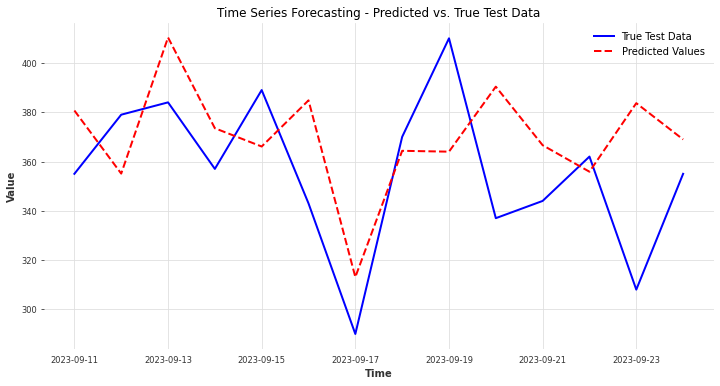

In [28]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import time
import warnings
from NBEATSModel import NBEATSModel

forecasting = NBEATSModel(train_real, test_real)

start_time = time.time()

best_params, best_evaluation_metric = forecasting.optimize_hyperparameters(n_trials=100)
print("Best Hyperparameters:", best_params)
print("Best Evaluation Metric:", best_evaluation_metric)

best_model = forecasting.train_best_model(best_params)

rmse_value, mape_value, smape_value, predicted_values_NBEATS = forecasting.evaluate_model(best_model)

# Calculate the total execution time
execution_time = round((time.time() - start_time), 3)
print("Execution Time:", execution_time)
print("RMSE:", rmse_value)
print("MAPE:", mape_value)
print("SMAPE:", smape_value)

# Fill in the comparison matrix (if available)
# Replace `comparison_matrix` with your actual comparison matrix if needed.
comparison_matrix.loc["NBEATS", "RMSE"] = rmse_value
comparison_matrix.loc["NBEATS", "MAPE"] = mape_value
comparison_matrix.loc["NBEATS", "SMAPE"] = smape_value
comparison_matrix.loc["NBEATS", "Execution Time (sec.)"] = execution_time

forecasting.plot_forecast(best_model)

Now, we will portray models' predictions and compare them. 

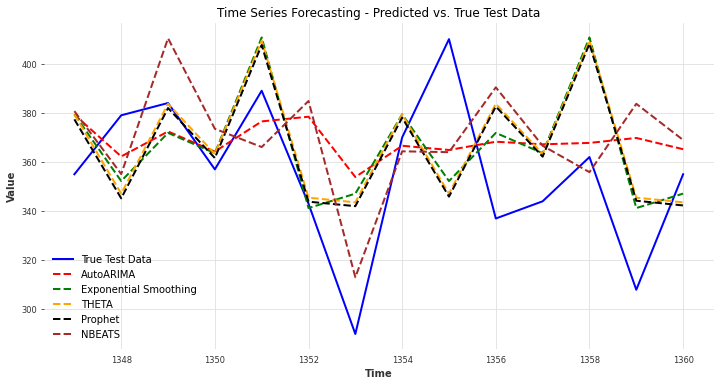

In [29]:
# Create a larger figure
plt.figure(figsize=(12, 6))

# Plot the true test data
plt.plot(time_index[len(train_real):], test_real.values, label='True Test Data', color='blue', linewidth=2)

# Plot the predicted values for AutoARIMA
plt.plot(time_index[len(train_real):], predicted_values_AutoARIMA, label='AutoARIMA', color='red', linestyle='dashed', linewidth=2)

# Plot the predicted values for Exponential Smoothing
plt.plot(time_index[len(train_real):], predicted_values_ExponentialSmoothing, label='Exponential Smoothing', color='green', linestyle='dashed', linewidth=2)

# Plot the predicted values for THETA
plt.plot(time_index[len(train_real):], predicted_values_THETA.univariate_values(), label='THETA', color='orange', linestyle='dashed', linewidth=2)

# Plot the predicted values for Prophet
plt.plot(time_index[len(train_real):], predicted_values_Prophet.univariate_values(), label='Prophet', color='black', linestyle='dashed', linewidth=2)

# Plot the predicted values for NBEATS
plt.plot(time_index[len(train_real):], predicted_values_NBEATS["NBEATS"], label='NBEATS', color='brown', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecasting - Predicted vs. True Test Data')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [30]:
comparison_matrix

,RMSE,MAPE,SMAPE,Execution Time (sec.)
AutoARIMA,31.690971,0.074509,7.121841,15.361
ExponentialSmoothing,31.396011,0.074182,7.214140,51.344
THETA,33.072318,0.076675,7.465455,29.113
Prophet,32.625588,0.074786,7.306331,82.554
NBEATS,34.304353,0.083173,7.985222,1239.139


In summary, univariate time series forecasting presents a complex challenge that requires careful consideration. It is essential to emphasize the pivotal role of data preprocessing in this analysis. Statistical models typically operate under the assumption of stationarity in the time series. In our study, we achieved stationarity through differencing the dataset.

Regarding model selection, it is our belief that the various models demonstrated comparable performance. While the AutoARIMA model emerged as the most efficient option, its performance did not exhibit a significant divergence from the other models.